In [2]:
# Segmentación de clientes con K-means
## Dataset: Online Retail II (UCI)


In [26]:
# 1. Carga de librerías
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split


In [4]:
# 2 CARGA DEL ARCHIVO EN DOS DATASETS

In [27]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd

# Ruta exacta de tu archivo
path = r'/content/drive/MyDrive/Colab Notebooks/Modelos 2025/online_retail_II.xlsx'

# Cargar pestañas
df1 = pd.read_excel(path, sheet_name='Year 2009-2010')
df2 = pd.read_excel(path, sheet_name='Year 2010-2011')

# Unir
df_raw = pd.concat([df1, df2], ignore_index=True)

df_raw.head()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [28]:
# ============================================================
# 3. PREPROCESAMIENTO COMPLETO (UNA SOLA CELDA)
# ============================================================

# Partimos del DataFrame unificado
df = df_raw.copy()

# 3.1 Ver columnas y estructura básica
print("=== Columnas del DataFrame original ===")
print(df.columns, "\n")

print("=== Info del DataFrame ===")
df.info()
print("\n")

# 3.2 Eliminar filas sin Customer ID
# No podemos segmentar a alguien sin identificador.
df = df.dropna(subset=['Customer ID'])

# 3.3 Eliminar devoluciones / registros negativos
# En este dataset el precio está en la columna 'Price'.
df = df[(df['Quantity'] > 0) & (df['Price'] > 0)]

# 3.4 Crear TotalPrice = Quantity * Price
df['TotalPrice'] = df['Quantity'] * df['Price']

# 3.5 Asegurar formato de fecha
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# 3.6 Definir fecha de referencia para Recency
ref_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)
print("Fecha de referencia (para Recency):", ref_date, "\n")

# 3.7 Construir tabla RFM
#   Recency  = días desde la última compra
#   Frequency= número de facturas distintas (actividad)
#   Monetary = importe total gastado
rfm = (
    df
    .groupby('Customer ID')
    .agg(
        Recency   = ('InvoiceDate', lambda x: (ref_date - x.max()).days),
        Frequency = ('Invoice', 'nunique'),
        Monetary  = ('TotalPrice', 'sum')
    )
    .reset_index()
)

print("=== Primeras filas de la tabla RFM ===")
rfm.head()


=== Columnas del DataFrame original ===
Index(['Invoice', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'Price', 'Customer ID', 'Country'],
      dtype='object') 

=== Info del DataFrame ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1067371 entries, 0 to 1067370
Data columns (total 8 columns):
 #   Column       Non-Null Count    Dtype         
---  ------       --------------    -----         
 0   Invoice      1067371 non-null  object        
 1   StockCode    1067371 non-null  object        
 2   Description  1062989 non-null  object        
 3   Quantity     1067371 non-null  int64         
 4   InvoiceDate  1067371 non-null  datetime64[ns]
 5   Price        1067371 non-null  float64       
 6   Customer ID  824364 non-null   float64       
 7   Country      1067371 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 65.1+ MB


Fecha de referencia (para Recency): 2011-12-10 12:50:00 

=== Primeras filas de la tabl

,Customer ID,Recency,Frequency,Monetary
0,12346.0,326,12,77556.46
1,12347.0,2,8,5633.32
2,12348.0,75,5,2019.40
3,12349.0,19,4,4428.69
4,12350.0,310,1,334.40


In [7]:
# ============================================================
# 4. SPLIT DATA (NO APLICA DIRECTAMENTE EN ESTE MODELO)
# ============================================================

# En modelos supervisados (clasificación / regresión) normalmente separamos
# los datos en entrenamiento y prueba para evaluar qué tan bien generaliza
# el modelo a datos nuevos.

# En este caso estamos trabajando con clustering (K-means),
# un enfoque NO supervisado sin variable objetivo (y).
# El objetivo es descubrir la estructura de los datos y segmentar clientes.

# Por esta razón, entrenaremos el modelo usando TODO el dataset RFM,
# ya que cada cliente aporta información relevante sobre la estructura
# de los clusters.



In [29]:
# ============================================================
# 5. VECTORIZACIÓN / ESCALADO
# ============================================================

# NOTA:
# En este proyecto no se requiere vectorización porque las
# variables RFM ya son numéricas.
#
# Sin embargo, K-means sí requiere que las variables estén
# escaladas para que tengan la misma importancia.
#
# Por lo tanto, en lugar de vectorizar, aplicamos StandardScaler.


from sklearn.preprocessing import StandardScaler

features = ['Recency', 'Frequency', 'Monetary']
X = rfm[features].copy()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_scaled_df = pd.DataFrame(X_scaled, columns=features, index=rfm['Customer ID'])

print("=== Primeras filas del RFM escalado ===")
X_scaled_df.head()


=== Primeras filas del RFM escalado ===


,Recency,Frequency,Monetary
Customer ID,,,
12346.0,0.595584,0.438998,5.058050
12347.0,-0.952279,0.131502,0.177431
12348.0,-0.603532,-0.099120,-0.067806
12349.0,-0.871064,-0.175994,0.095686
12350.0,0.519146,-0.406616,-0.182148


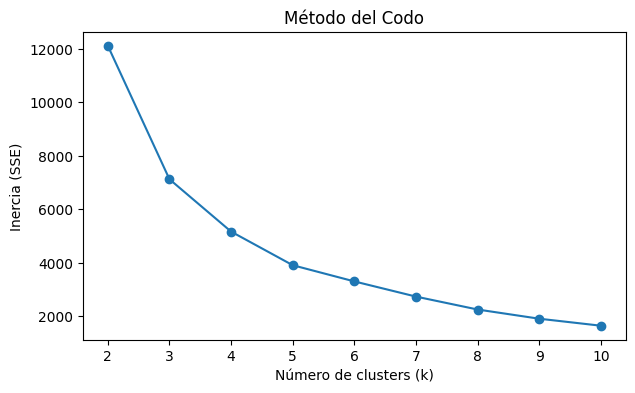

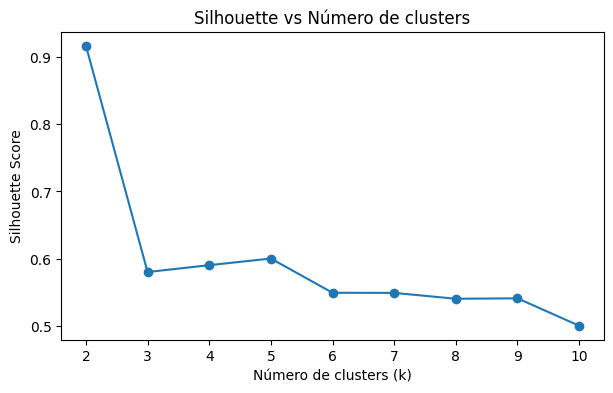

[(2, np.float64(0.9163500595338631)),
 (3, np.float64(0.5803628394922029)),
 (4, np.float64(0.5905244621382488)),
 (5, np.float64(0.6004114523686472)),
 (6, np.float64(0.54954446742698)),
 (7, np.float64(0.5493743834416007)),
 (8, np.float64(0.5406619708176821)),
 (9, np.float64(0.5413136449512954)),
 (10, np.float64(0.5006338014419282))]

In [30]:
# ============================================================
# 6. BÚSQUEDA DEL NÚMERO ÓPTIMO DE CLUSTERS (K)
# ============================================================

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

inertias = []
silhouettes = []
K_range = range(2, 11)  # probamos de 2 a 10 clusters

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_scaled_df)

    inertias.append(kmeans.inertia_)
    silhouettes.append(silhouette_score(X_scaled_df, labels))

# -----------------------------
# Gráfica del método del codo
# -----------------------------
plt.figure(figsize=(7,4))
plt.plot(list(K_range), inertias, marker='o')
plt.xlabel('Número de clusters (k)')
plt.ylabel('Inercia (SSE)')
plt.title('Método del Codo')
plt.show()

# -----------------------------
# Gráfica del silhouette
# -----------------------------
plt.figure(figsize=(7,4))
plt.plot(list(K_range), silhouettes, marker='o')
plt.xlabel('Número de clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette vs Número de clusters')
plt.show()

# Mostramos los valores obtenidos
list(zip(K_range, silhouettes))


In [31]:
# ============================================================
# 7. ENTRENAMIENTO DEL MODELO K-MEANS (K = 4)
# ============================================================

from sklearn.cluster import KMeans

k_opt = 4

kmeans_4 = KMeans(n_clusters=k_opt, random_state=42, n_init=10)
rfm['Cluster_K4'] = kmeans_4.fit_predict(X_scaled_df)

print("=== Primeras filas con Cluster K=4 asignado ===")
rfm.head()


=== Primeras filas con Cluster K=4 asignado ===


,Customer ID,Recency,Frequency,Monetary,Cluster_K4
0,12346.0,326,12,77556.46,1
1,12347.0,2,8,5633.32,1
2,12348.0,75,5,2019.40,1
3,12349.0,19,4,4428.69,1
4,12350.0,310,1,334.40,0


In [32]:
# Tamaño de cada cluster
print("=== Tamaño de cada cluster (K=4) ===")
print(rfm['Cluster_K4'].value_counts().sort_index())

# Perfil promedio por cluster
cluster_profile_4 = rfm.groupby('Cluster_K4')[['Recency','Frequency','Monetary']].mean().round(2)

print("\n=== Perfil promedio RFM por cluster (K=4) ===")
cluster_profile_4


=== Tamaño de cada cluster (K=4) ===
Cluster_K4
0    1998
1    3841
2      35
3       4
Name: count, dtype: int64

=== Perfil promedio RFM por cluster (K=4) ===


,Recency,Frequency,Monetary
Cluster_K4,,,
0,463.03,2.21,765.24
1,67.01,7.31,3009.40
2,25.94,103.71,83086.08
3,3.50,212.50,436835.79


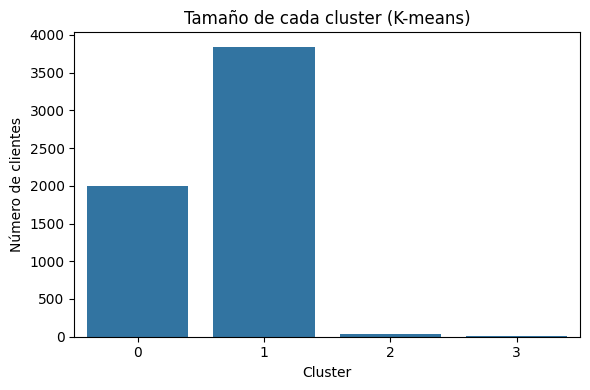

In [33]:
# ============================================================
# GRAFICA 1: TAMAÑO DE CADA CLUSTER (K-MEANS K=4)
# ============================================================

import matplotlib.pyplot as plt
import seaborn as sns

cluster_col = 'Cluster_K4'  # cámbiala a 'Cluster_K5' si quieres

cluster_counts = rfm[cluster_col].value_counts().sort_index()

plt.figure(figsize=(6,4))
sns.barplot(x=cluster_counts.index, y=cluster_counts.values)
plt.xlabel('Cluster')
plt.ylabel('Número de clientes')
plt.title('Tamaño de cada cluster (K-means)')
plt.tight_layout()
plt.show()


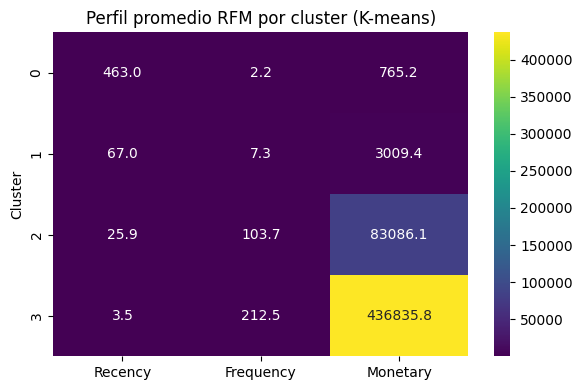

,Recency,Frequency,Monetary
Cluster_K4,,,
0,463.0,2.2,765.2
1,67.0,7.3,3009.4
2,25.9,103.7,83086.1
3,3.5,212.5,436835.8


In [34]:
# ============================================================
# GRAFICA 2: HEATMAP RFM PROMEDIO POR CLUSTER
# ============================================================

features = ['Recency', 'Frequency', 'Monetary']
cluster_profile = (
    rfm.groupby(cluster_col)[features]
       .mean()
       .round(1)
)

plt.figure(figsize=(6,4))
sns.heatmap(cluster_profile, annot=True, fmt=".1f", cmap='viridis')
plt.title('Perfil promedio RFM por cluster (K-means)')
plt.ylabel('Cluster')
plt.tight_layout()
plt.show()

cluster_profile


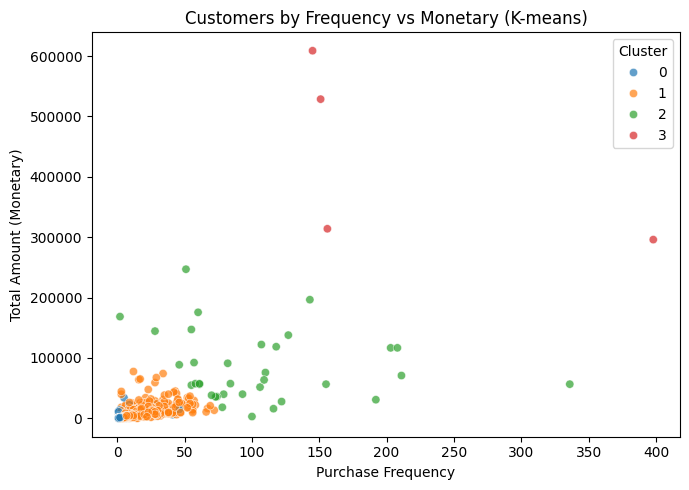

In [36]:
# ============================================================
# GRAFICA 3: FREQUENCY vs MONETARY POR CLUSTER
# ============================================================

plt.figure(figsize=(7,5))
sns.scatterplot(
    data=rfm,
    x='Frequency',
    y='Monetary',
    hue=cluster_col,
    palette='tab10',
    alpha=0.7
)
plt.xlabel('Purchase Frequency')
plt.ylabel('Total Amount (Monetary)')
plt.title('Customers by Frequency vs Monetary (K-means)')
plt.legend(title='Cluster')
plt.tight_layout()
plt.show()


In [14]:
# Tamaño de cada cluster
print("=== Tamaño de cada cluster (K=5) ===")
print(rfm['Cluster_K5'].value_counts().sort_index())

# Perfil promedio por cluster
cluster_profile_5 = rfm.groupby('Cluster_K5')[['Recency','Frequency','Monetary']].mean().round(2)

print("\n=== Perfil promedio RFM por cluster (K=5) ===")
cluster_profile_5


=== Tamaño de cada cluster (K=5) ===
Cluster_K5
0     383
1    1917
2      24
3       4
4    3550
Name: count, dtype: int64

=== Perfil promedio RFM por cluster (K=5) ===


,Recency,Frequency,Monetary
Cluster_K5,,,
0,28.10,28.53,13935.16
1,471.23,2.17,755.65
2,22.46,119.79,100927.04
3,3.50,212.50,436835.79
4,75.71,5.12,1912.14


In [15]:
# ============================================================
# CLUSTERING CON DBSCAN
# ============================================================

from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
import numpy as np

# Hiperparámetros iniciales (AJÚSTALOS)
eps_value = 0.8      # radio de vecindad en el espacio escalado
min_samples_value = 20  # puntos mínimos por vecindad

dbscan = DBSCAN(eps=eps_value, min_samples=min_samples_value)
labels_db = dbscan.fit_predict(X_scaled_df)

# Guardamos etiquetas en rfm
rfm['Cluster_DBSCAN'] = labels_db

# Clusters detectados (-1 = ruido / outliers)
print("Etiquetas DBSCAN (incluye -1 como ruido):")
print(np.unique(labels_db))

# Silhouette solo si hay al menos 2 clusters reales
unique_clusters = [c for c in np.unique(labels_db) if c != -1]
if len(unique_clusters) >= 2:
    mask = labels_db != -1
    sil_db = silhouette_score(X_scaled_df[mask], labels_db[mask])
    print(f"\nSilhouette DBSCAN (sin ruido): {sil_db:.3f}")
else:
    print("\nNo hay suficientes clusters válidos para calcular silhouette.")

# Resumen de tamaño por cluster (incluyendo ruido)
print("\n=== Tamaño de cada cluster DBSCAN ===")
print(rfm['Cluster_DBSCAN'].value_counts().sort_index())

# Perfil RFM por cluster (excluyendo ruido -1)
cluster_profile_db = (
    rfm[rfm['Cluster_DBSCAN'] != -1]
    .groupby('Cluster_DBSCAN')[['Recency','Frequency','Monetary']]
    .mean()
    .round(2)
)

print("\n=== Perfil promedio RFM por cluster (DBSCAN, sin ruido) ===")
cluster_profile_db


Etiquetas DBSCAN (incluye -1 como ruido):
[-1  0]

No hay suficientes clusters válidos para calcular silhouette.

=== Tamaño de cada cluster DBSCAN ===
Cluster_DBSCAN
-1      62
 0    5816
Name: count, dtype: int64

=== Perfil promedio RFM por cluster (DBSCAN, sin ruido) ===


,Recency,Frequency,Monetary
Cluster_DBSCAN,,,
0,202.67,5.45,2094.12


In [ ]:
!pip install hdbscan

In [ ]:
# ============================================================
# CLUSTERING CON HDBSCAN
# ============================================================

import hdbscan
from sklearn.metrics import silhouette_score
import numpy as np

# min_cluster_size = tamaño mínimo de cluster
# min_samples = similar a DBSCAN (robustez frente a ruido)
hdb = hdbscan.HDBSCAN(min_cluster_size=30, min_samples=10)
labels_hdb = hdb.fit_predict(X_scaled_df)

rfm['Cluster_HDBSCAN'] = labels_hdb

print("Etiquetas HDBSCAN (incluye -1 como ruido):")
print(np.unique(labels_hdb))

# Silhouette (si hay >= 2 clusters válidos)
unique_clusters_hdb = [c for c in np.unique(labels_hdb) if c != -1]
if len(unique_clusters_hdb) >= 2:
    mask_hdb = labels_hdb != -1
    sil_hdb = silhouette_score(X_scaled_df[mask_hdb], labels_hdb[mask_hdb])
    print(f"\nSilhouette HDBSCAN (sin ruido): {sil_hdb:.3f}")
else:
    print("\nNo hay suficientes clusters válidos para calcular silhouette.")

print("\n=== Tamaño de cada cluster HDBSCAN ===")
print(rfm['Cluster_HDBSCAN'].value_counts().sort_index())

cluster_profile_hdb = (
    rfm[rfm['Cluster_HDBSCAN'] != -1]
    .groupby('Cluster_HDBSCAN')[['Recency','Frequency','Monetary']]
    .mean()
    .round(2)
)

print("\n=== Perfil promedio RFM por cluster (HDBSCAN, sin ruido) ===")
cluster_profile_hdb


In [ ]:
# ============================================================
# CLUSTERING CON GAUSSIAN MIXTURE MODELS (GMM)
# ============================================================

from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score

n_components = 4  # puedes probar 4 o 5 para comparar con K-means

gmm = GaussianMixture(n_components=n_components, random_state=42)
gmm_labels = gmm.fit_predict(X_scaled_df)

rfm['Cluster_GMM'] = gmm_labels

# Silhouette
sil_gmm = silhouette_score(X_scaled_df, gmm_labels)
print(f"Silhouette GMM (k={n_components}): {sil_gmm:.3f}")

print("\n=== Tamaño de cada cluster GMM ===")
print(rfm['Cluster_GMM'].value_counts().sort_index())

cluster_profile_gmm = (
    rfm
    .groupby('Cluster_GMM')[['Recency','Frequency','Monetary']]
    .mean()
    .round(2)
)

print("\n=== Perfil promedio RFM por cluster (GMM) ===")
cluster_profile_gmm
